In [1]:
import os
os.chdir("../..")

%load_ext autoreload
%autoreload 2

In [206]:
from fastqaoa.ctypes.optimize import optimize_qaoa_lbfgs
from fastqaoa.ctypes.qpe_qaoa import qpe_qaoa
from fastqaoa.indicator import get_indicator_base, get_indicator_interpolator, interpolate_diagonals
from fastqaoa.params import interpolate
from fastqaoa.ctypes.metrics import Metrics

from problems import Knapsack

import numpy as np
import matplotlib.pyplot as plt

from typing import List
import pandas as pd
from tqdm import tqdm
import seaborn as sns

from matplotlib import cm, colors

In [3]:
N = 12
n = 64


problems: List[Knapsack] = Knapsack.get_instances()[N][:n]

In [4]:
M = 4

# base = get_indicator_base(M, 4)
interp = get_indicator_interpolator(M, 4, shift=0)
interp2 = get_indicator_interpolator(M, 4, shift=2)

In [5]:
x = np.linspace(-1, 1, 500)

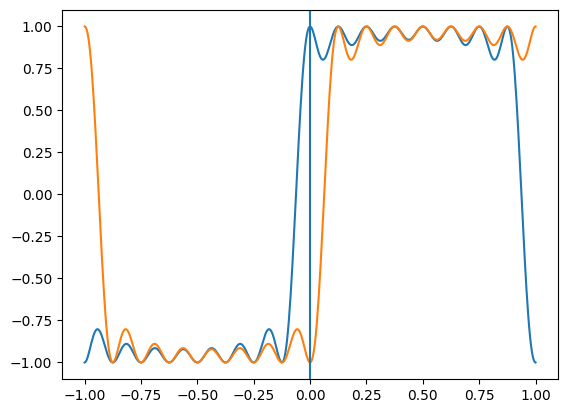

In [6]:
plt.plot(x, interp(x))
plt.plot(x, interp2(x))
plt.axvline(0)

In [7]:
def get_dg_cost_constr(problem: Knapsack, interp):
    cost, weights = problem.diagonalized()
    constr = weights.scale_between_sym(1)
    cost = cost.scale_between_sym(cost.n_qubits)
    return cost, problem.masked_cost(), interpolate_diagonals(interp, constr), weights

In [8]:
ps = [1, 2, 4, 8, 16]

beta0 = [0.1]
gamma0 = [0.1]

def optimize_interpolting(problem: Knapsack, interp, shift, M):
    dg, cost, constr, weights = get_dg_cost_constr(problem, interp)
    betas = beta0
    gammas = gamma0
    data = []
    for p in ps:
        betas, gammas = interpolate(p, betas, gammas)
        res = optimize_qaoa_lbfgs(dg, cost, betas=betas, gammas=gammas, constr=constr)
        sv, psucc = qpe_qaoa(dg, constr, res.betas, res.gammas)
        data.append({
            "instance": problem.id, 
            "n_qubits": problem.n_qubits, 
            "p": p, 
            "psucc": psucc,
            "shift": shift,
            "M": M,
            **Metrics.compute(sv, cost, weights).dump()
        })
    return data

In [210]:
shifts = np.linspace(0, 2, 10, endpoint=False).round(3)
# shifts = np.linspace(0.5, 0.6, 2, endpoint=False).round(3)
print(shifts)
Ms = [4, 6, 8, 16]

interps = {(M, s): get_indicator_interpolator(M, 4, shift=s) for M in Ms for s in shifts}

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


In [162]:
# res = []

for p in tqdm(problems):
    for (M, s), interp in interps.items():
       res += optimize_interpolting(p, interp, s, M)
    p.decache()

df = pd.DataFrame(res)
df.to_feather("notebooks/experiments/qpe_shift2.feather")

100%|███████████████████████████████████████████████████████████████████████████████████| 64/64 [07:14<00:00,  6.79s/it]


In [243]:
df = pd.read_feather("notebooks/experiments/qpe_shift.feather")
df2 = pd.read_feather("notebooks/experiments/qpe_shift2.feather")
df = df2
# df = pd.concat([df, df2], ignore_index=True)

In [245]:
df["approx_ratio_new"] = df.approx_ratio / df.groupby(["instance", "M", "p"]).approx_ratio.transform("max")
df["approx_ratio_norm"] = df.approx_ratio * df.psucc
df["approx_ratio_norm_new"] = df.approx_ratio_norm / df.groupby(["instance", "M", "p"]).approx_ratio_norm.transform("max")
df["psucc1"] = df.psucc ** (1 / df.p)
df["psucc_new"] = df.psucc1 / df.groupby(["instance", "M", "p"]).psucc1.transform("max")
df["feas_ratio_nw"] = df.feas_ratio / df.groupby(["instance", "M", "p"]).feas_ratio.transform("max")
df["scaling"] = df.p / (df.psucc * df.p_opt)
df["scaling_new"] = df.scaling / df.groupby(["instance", "M", "p"]).scaling.transform("min")

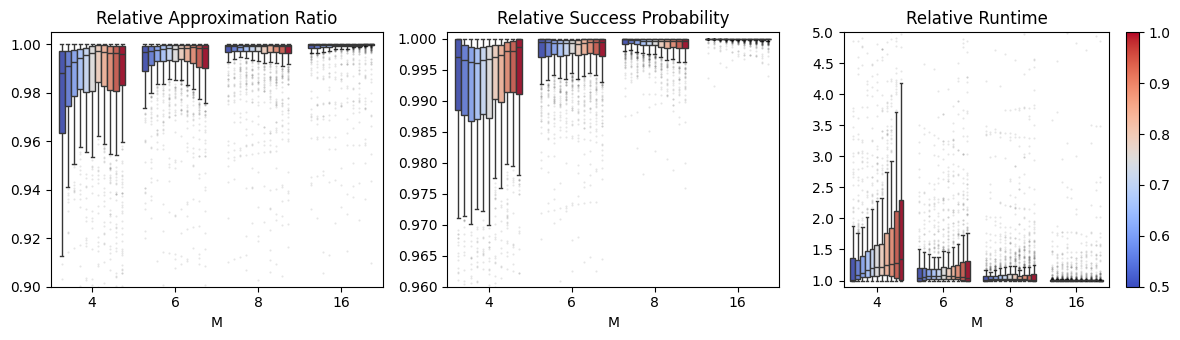

In [248]:
# dfx = df.query("p == 1")d
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

dfx = df #.query("p == 4")

ax = axs[0]
flierprops={"markersize": 3, "alpha": 0.1, "marker": ".", "markeredgewidth": 0, "markerfacecolor": "k"}
df["approx_ratio_new'"] = 1 - df["approx_ratio_new"]
m = sns.boxplot(dfx, x="M", y="approx_ratio_new", hue="shift", flierprops=flierprops, palette="coolwarm", ax=ax, legend=False)
ax.set_ylim(0.9, 1.005)
ax.set_ylabel(None)
ax.set_title("Relative Approximation Ratio")

ax = axs[1]
flierprops={"markersize": 3, "alpha": 0.1, "marker": ".", "markeredgewidth": 0, "markerfacecolor": "k"}
df["approx_ratio_new'"] = 1 - df["approx_ratio_new"]
m = sns.boxplot(dfx, x="M", y="psucc_new", hue="shift", flierprops=flierprops, palette="coolwarm", ax=ax, legend=False)
ax.set_ylim(0.96, 1.001)
ax.set_ylabel(None)
ax.set_title("Relative Success Probability")


ax = axs[2]
flierprops={"markersize": 3, "alpha": 0.1, "marker": ".", "markeredgewidth": 0, "markerfacecolor": "k"}
df["approx_ratio_new'"] = 1 - df["approx_ratio_new"]
m = sns.boxplot(dfx, x="M", y="scaling_new", hue="shift", flierprops=flierprops, palette="coolwarm", ax=ax, legend=False)
ax.set_ylim(0.9, 5)
ax.set_ylabel(None)
ax.set_title("Relative Runtime")

norm = colors.Normalize(0.5, 1)
fig.colorbar(cm.ScalarMappable(norm=norm,cmap='coolwarm'), ax=axs[-1])

fig.tight_layout()
fig.savefig("qpe_shit_close.pdf", bbox_inches="tight")

<Axes: xlabel='M', ylabel='p_opt'>

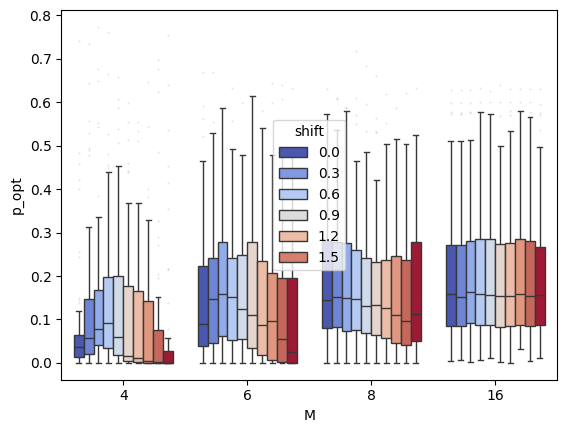

In [236]:
dfx = df.query("p == 16")
flierprops={"markersize": 3, "alpha": 0.1, "marker": ".", "markeredgewidth": 0, "markerfacecolor": "k"}
sns.boxplot(dfx, x="M", y="p_opt", hue="shift", flierprops=flierprops, palette="coolwarm")
# plt.ylim((0.5, None))